In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

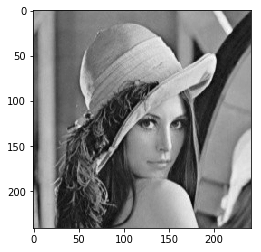

In [2]:
img = cv2.imread("portraits/theLady.jpeg", 0)
plt.imshow(img, cmap='gray')

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img, 1.1, 4)
(x, y, w, h) = faces[np.argmax(faces[:,-1])]

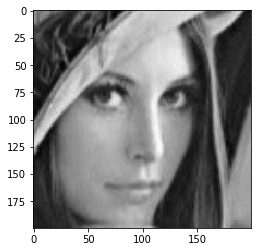

In [4]:
crop_img = cv2.resize(img[int(y-0.1*h):int(y+1.1*h), int(x-0.1*w):int(x+1.1*w)], (200, 200))
plt.imshow(crop_img, cmap='gray')

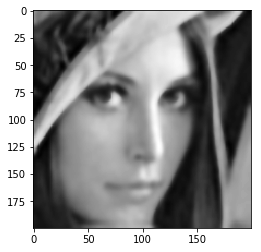

In [5]:
blur_img = cv2.bilateralFilter(crop_img, 7, 50, 50)
plt.imshow(blur_img, cmap='gray')

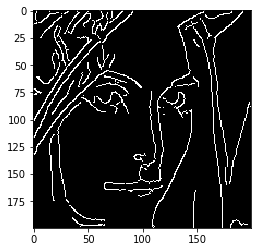

In [6]:
edge_img = cv2.Canny(blur_img, 30, 60)
plt.imshow(edge_img, cmap='gray')

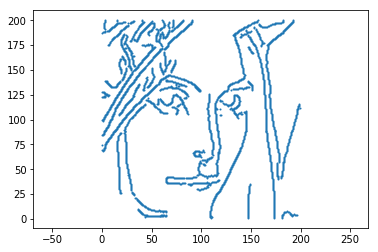

In [7]:
edge_indexs = np.argwhere(edge_img != 0)
edge_points = np.zeros(edge_indexs.shape)
edge_points[:,0] = edge_indexs[:,1]
edge_points[:,1] = 200 - edge_indexs[:,0]

# 不太好的 downsample
# edge_points = edge_points[np.random.choice(len(edge_points), 1000)]

plt.axis('equal')
plt.scatter(edge_points[:,0], edge_points[:,1], s=1)

In [8]:
n = len(edge_points)

In [9]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
adjMat = np.zeros((n, n))
for i in range(n):
    adjMat[i, :] = np.linalg.norm(edge_points - edge_points[i], axis=1)
adjMat = csr_matrix(adjMat)
adjMatMst = minimum_spanning_tree(adjMat)

In [ ]:
x = edge_points[:,0].flatten()
y = edge_points[:,1].flatten()
edges = np.argwhere(adjMatMst.toarray()>0)

plt.axis('equal')
plt.plot(x[edges.T], y[edges.T], c='tab:blue')
plt.show()

In [ ]:
from scipy.sparse.csgraph import depth_first_order
start = divmod(np.argmax(adjMatMst), len(edge_points))[0]
path, predecessors = depth_first_order(adjMatMst, start, directed=False)

In [ ]:
fp = []
for i in range(len(path)-1):
    curVertex = path[i]
    fp.append(curVertex)
    nextVertex = path[i+1]
    while predecessors[nextVertex] != curVertex:
        curVertex = predecessors[curVertex]
        fp.append(curVertex)
fp.append(path[-1])
fp = np.array(fp)

In [ ]:
edges = np.argwhere(adjMatMst.toarray()>0)
print(sum([np.linalg.norm(edge_points[e[0]]-edge_points[e[1]]) for e in edges]))
edges = np.hstack((fp[:-1].reshape(-1,1), fp[1:].reshape(-1,1)))
print(sum([np.linalg.norm(edge_points[e[0]]-edge_points[e[1]]) for e in edges]))

In [ ]:
edges = np.hstack((fp[:-1].reshape(-1,1), fp[1:].reshape(-1,1)))

In [ ]:
plt.axis('equal')
plt.plot(x[edges.T], y[edges.T], c='tab:blue')
plt.show()

In [ ]:
# 比较好的 downsample
# 居然成了。。。
def RamerDouglasPeucker(path, epsilon=2):
    start = 0
    end = len(path) - 1
    vec1 = (edge_points[path[end]] - edge_points[path[start]]).reshape(-1,1)
    vecs = edge_points[path] - edge_points[path[start]]
    projMat = vec1.dot(vec1.T) / np.linalg.norm(vec1) ** 2
    errVec = (np.eye(2) - projMat).dot(vecs.T)
    errNorm = np.linalg.norm(errVec.T, axis=1)
    imax = np.argmax(errNorm)
    dmax = errNorm[imax]
    if dmax >= epsilon:
        return np.vstack((RamerDouglasPeucker(path[start:imax+1]), RamerDouglasPeucker(path[imax:end+1])))
    else:
        return path[np.array([start, end])]

In [ ]:
edges = RamerDouglasPeucker(fp)

In [ ]:
plt.axis('equal')
plt.plot(x[edges.T], y[edges.T], c='tab:blue')
plt.show()

In [ ]:
# # 好像不太行

# %matplotlib notebook
# from matplotlib.animation import FuncAnimation

# fig = plt.figure()
# ax = plt.axes(xlim=(0, 200), ylim=(0, 200))
# ax.axis('equal')

# def update(i):
#     plt.plot(edge_points[edges[i],0], edge_points[edges[i],1], c='tab:blue')
#     return []

# ani = FuncAnimation(fig, update, frames=range(len(edges)), interval=5)
# plt.show()